In [3]:
!pip install ydata-profiling
!pip install rdkit-pypi
!pip install shap
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
#@jit(forceobj=True)

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import shap

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor



from sklearn.metrics import make_scorer ,mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error

from scipy.stats import skew

from sklearn.preprocessing import StandardScaler , FunctionTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate , cross_val_score


This train dataset contains both single-junctional OSCs with nonfullerene acceptors and tandem OSCs with nonfullerene acceptors (NFA).
The references of these different data and articles studied will be mentioned at the end of this work. 

We have collected the names of the donors and acceptors whose smiles had been lied to. ( Because one of the constraints of this project is that there was no software at our disposal allowing to find the smiles from the shortened names of molecules ) and with the help of the python library mordered which is an alternative to the software DRAGON 2.0 usually used ( which is not available anymore ) to generate descriptors ( about 1826 ) . This makes a total of about 3652 descriptors managed in our case ( 1826 for D and 1826 for A )



* The data of type D-NFA with single junction were collected and contained the quite a lot of information of which those which we retained were the name of the Donors, Acceptors, the corresponding smiles, PCE of the combinations D-A.

* Concerning the other type of data (D-NFA tandem), there were no smiles in the base. The collected data were only the PCE, the names of the D and A and we used the list of smiles at our disposal and mapped these smiles to the names of each molecule of this data.

**Note :**  You will see in this dataset some data where the names of the acceptors are not mentinonated ( and replaced by the NaN values ) . These data belong in fact to the category of D-NFA with single junction and the data were found as they are, but since it is especially the smiles which were important to generate the descriptors, these data were kept and used within the framework of our work.


How this was done will be detailed in another notebook.


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
data=pd.read_csv("/content/drive/MyDrive/train_data_with_virtualdesciptors.csv", low_memory=False)


acc_SMILES_column = data.pop('acc_SMILES')
data.insert(0, 'acc_SMILES', acc_SMILES_column)
don_SMILES_column= data.pop('don_SMILES')
data.insert(1, 'don_SMILES', don_SMILES_column)
reported_acc_column = data.pop('Reported Acceptor')
data.insert(2, 'Reported Acceptor', reported_acc_column)
reported_don_column = data.pop('Reported Donor ')
data.insert(3, 'Reported Donor ', reported_don_column)



DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [7]:
for i in data.columns :
    
    if data[i].dtype == np.float64 :
        data[i]=data[i].astype(np.float32)
    if data[i].dtype == np.int64 :
        data[i]=data[i].astype(np.int8)
        
   

In [8]:
pd.set_option('display.max_columns', None)
data.head()

acc_SMILES  \
0  CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5cc(/C=...   
1  CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5cc(/C=...   
2  CCc1c(/C=C2\C(=O)c3cc(F)c(F)cc3C2=C(C#N)C#N)sc...   
3  CCC1(CC)c2cc3c(cc2-c2sc(/C=C4\C(=O)c5ccccc5C4=...   
4  O=C1C2=C(C=CC=C2)C(/C1=C/C3=CC(C4(C5=CC=C(CCCC...   

                                          don_SMILES Reported Acceptor  \
0  CCCc1sc(-c2c3cc(-c4cc(C(=O)CC)c(-c5ccc(-c6sc(-...             IT-4F   
1  CCN1C(=O)/C(=C\c2csc(-c3ccc(-c4ccc(-c5sc(-c6cc...              ITIC   
2  CCOC(=O)/C(C#N)=C/c1ccc(-c2sc(-c3cc4c(-c5ccc(C...                Y6   
3  CCOC(=O)/C(C#N)=C\c1cc(CC)c(-c2ccc(-c3sc(-c4cc...              IDIC   
4  CCOC(=O)/C(C#N)=C\c1cc(CC)c(-c2ccc(-c3sc(-c4cc...               NaN   

  Reported Donor    ABC_donor  ABCGG_donor  nAcid_donor  nBase_donor  \
0       PBDT-3TCO  124.327255    84.118683            0            0   
1           PTIBT   68.613632    46.808445            0            0   
2          3BDT-5   96.424553    65.129272            0            0   
3           SM-Cl   66.015915    47.400455            0            0   
4           SM-Cl   66.015915    47.400455            0            0   

   SpAbs_A_donor  SpMax_A_donor  SpDiam_A_donor  SpAD_A_donor  SpMAD_A_donor  \
0     204.028152       2.635164        5.121447    204.028152       1.324858   
1     113.422150       2.538887        4.841794    113.422150       1.350264   
2     160.252380       2.651864        5.137436    160.252380       1.335436   
3     109.669403       2.632854        5.119109    109.669403       1.305588   
4     109.669403       2.632854        5.119109    109.669403       1.305588   

   LogEE_A_donor  VE1_A_donor  VE2_A_donor  VE3_A_donor   VR1_A_donor  \
0       6.002738     8.308157     0.053949     4.851605  13929.402344   
1       5.404533     7.516350     0.089480     4.145312   2202.665527   
2       5.750998     7.829957     0.065250     4.542864  33798.625000   
3       5.376136     5.628560     0.067007     3.856085  32903.199219   
4       5.376136     5.628560     0.067007     3.856085  32903.199219   

   VR2_A_donor  VR3_A_donor  nAromAtom_donor  nAromBond_donor  nAtom_donor  \
0    90.450661    12.276125              111              117          -14   
1    26.222210     9.825655               63               63         -125   
2   281.655212    12.913082               86               92          -60   
3   391.704742    12.529557               52               54         -118   
4   391.704742    12.529557               52               54         -118   

   nHeavyAtom_donor  nSpiro_donor  nBridgehead_donor  nHetero_donor  nH_donor  \
0              -102             0                  0             33        88   
1                84             0                  0             15        47   
2               120             0                  0             22        76   
3                84             0                  0             18        54   
4                84             0                  0             18        54   

   nB_donor  nC_donor  nN_donor  nO_donor  nS_donor  nP_donor  nF_donor  \
0         0       121         0         6        21         0         6   
1         0        69         3         3         9         0         0   
2         0        98         2         4        16         0         0   
3         0        66         2         4        10         0         0   
4         0        66         2         4        10         0         0   

   nCl_donor  nBr_donor  nI_donor  nX_donor  ATS0dv_donor  ATS1dv_donor  \
0          0          0         0         6   1937.333374   1919.666626   
1          0          0         0         0    986.000000   1082.666626   
2          0          0         0         0   1317.111084   1409.333374   
3          2          0         0         2    941.654297    973.555542   
4          2          0         0         2    941.654297    973.555542   

   ATS2dv_donor  ATS3dv_donor  ATS4dv_donor  ATS5

# DATA PREPROCESSING

In [ ]:
"""profile = ProfileReport(
    data.tail(100),
    title="Profiling Report For D-NFA dataset with descriptors ",
    html={'style':{'full_width':True}}
)

profile.to_file(output_file = "data_NFA_with_descriptors-profile.html")"""

'profile = ProfileReport(\n    data.tail(100),\n    title="Profiling Report For D-NFA dataset with descriptors ",\n    html={\'style\':{\'full_width\':True}}\n)\n\nprofile.to_file(output_file = "data_NFA_with_descriptors-profile.html")'

In [9]:
data.shape

(1280, 3657)

In [10]:
data.describe()

ABC_donor  ABCGG_donor  nAcid_donor  nBase_donor  SpAbs_A_donor  \
count  1280.000000  1280.000000       1280.0       1280.0    1280.000000   
mean    115.144569    76.807411          0.0          0.0     189.352417   
std      33.486267    20.495869          0.0          0.0      54.816975   
min      34.422169    27.752886          0.0          0.0      57.516518   
25%      97.791046    67.506119          0.0          0.0     160.643951   
50%     133.085129    87.677505          0.0          0.0     219.375992   
75%     137.741470    91.420303          0.0          0.0     225.138229   
max     206.311035   129.996307          0.0          0.0     342.812286   

       SpMax_A_donor  SpDiam_A_donor  SpAD_A_donor  SpMAD_A_donor  \
count    1280.000000     1280.000000   1280.000000    1280.000000   
mean        2.633332        5.102145    189.352417       1.338924   
std         0.037965        0.103328     54.816975       0.015732   
min         2.518369        4.764818     57.516518       1.285203   
25%         2.632939        5.122446    160.643951       1.334269   
50%         2.647700        5.133273    219.375992       1.340109   
75%         2.648991        5.135246    225.138229       1.354173   
max         2.901166        5.736760    342.812286       1.383039   

       LogEE_A_donor  VE1_A_donor  VE2_A_donor  VE3_A_donor   VR1_A_donor  \
count    1280.000000  1280.000000  1280.000000  1280.000000  1.280000e+03   
mean        5.863101     9.032965     0.069279     4.771083  2.240018e+11   
std         0.403963     1.433163     0.020214     0.565183  8.014133e+12   
min         4.731587     4.283864     0.022312     3.233786  4.594016e+02   
25%         5.764914     8.510837     0.061370     4.626247  4.681626e+03   
50%         6.072076     9.466129     0.062235     5.095773  6.396904e+03   
75%         6.106171    10.082102     0.070924     5.132521  7.464048e+03   
max         6.505197    11.442980     0.131072     5.664220  2.867224e+14   

        VR2_A_donor  VR3_A_donor  nAromAtom_donor  nAromBond_donor  \
count  1.280000e+03  1280.000000      1280.000000      1280.000000   
mean   1.166676e+09    11.177503        87.207031       -50.193750   
std    4.174028e+10     1.414886        65.074602        96.680163   
min    1.044095e+01     7.611529      -127.000000      -127.000000   
25%    3.736275e+01    10.936307        87.000000      -124.000000   
50%    3.948706e+01    11.548580       123.000000      -124.000000   
75%    5.070309e+01    11.605700       126.000000        54.000000   
max    1.493346e+12    36.244446       126.000000       120.000000   

       nAtom_donor  nHeavyAtom_donor  nSpiro_donor  nBridgehead_donor  \
count  1280.000000       1280.000000        1280.0             1280.0   
mean     -6.689844        -29.889063           0.0                0.0   
std      52.931926         88.696019           0.0                0.0   
min    -125.000000       -127.000000           0.0                0.0   
25%     -32.000000        -94.000000           0.0                0.0   
50%      -2.000000        -88.000000           0.0                0.0   
75%      -2.000000         60.000000           0.0                0.0   
max     124.000000        126.000000           0.0                0.0   

       nHetero_donor     nH_donor  nB_donor     nC_donor     nN_donor  \
count    1280.000000  1280.000000    1280.0  1280.000000  1280.000000   
mean       29.717188    65.199219       0.0   -28.606250     2.399219   
std         9.092850    48.255479       0.0   103.605734     3.952315   
min         6.000000  -128.000000       0.0  -127.000000     0.000000   
25%        27.000000    65.000000       0.0  -124.000000     0.000000   
50%        30.000000    86.000000       0.0  -116.000000     0.000000   
75%        36.000000    92.000000       0.0    93.000000     6.000000   
max        66.000000   122.000000       0.0   126.000000    18.000000   

          nO_donor     nS_donor  nP_donor     nF_donor    nCl

In [11]:
zero_cols = data.columns[(data == 0).all()]
len(zero_cols)
data.drop(zero_cols, axis=1, inplace=True)

In [12]:
object_cols = data.select_dtypes(include=['object'])

"""print(len(object_cols))
for i in object_cols.columns :
    try  :
        if (sum(data[i].str.contains('missing 3D coordinate'))>20) or (sum(data[i].str.contains('min()'))>20) or (sum(data[i].str.contains('float division by zero'))>20) or (sum(data[i].str.contains('max()'))>20) :
            data.drop([i],axis=1, inplace=True)
    except :
        pass
"""

excluded_cols = ['acc_SMILES', 'don_SMILES', 'Reported Acceptor', 'Reported Donor ']
object_cols = object_cols.drop(columns=excluded_cols)

data.drop(object_cols.columns,axis=1, inplace=True)

In [13]:
data.shape

(1280, 2320)

In [14]:
data.head()

acc_SMILES  \
0  CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5cc(/C=...   
1  CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5cc(/C=...   
2  CCc1c(/C=C2\C(=O)c3cc(F)c(F)cc3C2=C(C#N)C#N)sc...   
3  CCC1(CC)c2cc3c(cc2-c2sc(/C=C4\C(=O)c5ccccc5C4=...   
4  O=C1C2=C(C=CC=C2)C(/C1=C/C3=CC(C4(C5=CC=C(CCCC...   

                                          don_SMILES Reported Acceptor  \
0  CCCc1sc(-c2c3cc(-c4cc(C(=O)CC)c(-c5ccc(-c6sc(-...             IT-4F   
1  CCN1C(=O)/C(=C\c2csc(-c3ccc(-c4ccc(-c5sc(-c6cc...              ITIC   
2  CCOC(=O)/C(C#N)=C/c1ccc(-c2sc(-c3cc4c(-c5ccc(C...                Y6   
3  CCOC(=O)/C(C#N)=C\c1cc(CC)c(-c2ccc(-c3sc(-c4cc...              IDIC   
4  CCOC(=O)/C(C#N)=C\c1cc(CC)c(-c2ccc(-c3sc(-c4cc...               NaN   

  Reported Donor    ABC_donor  ABCGG_donor  SpAbs_A_donor  SpMax_A_donor  \
0       PBDT-3TCO  124.327255    84.118683     204.028152       2.635164   
1           PTIBT   68.613632    46.808445     113.422150       2.538887   
2          3BDT-5   96.424553    65.129272     160.252380       2.651864   
3           SM-Cl   66.015915    47.400455     109.669403       2.632854   
4           SM-Cl   66.015915    47.400455     109.669403       2.632854   

   SpDiam_A_donor  SpAD_A_donor  SpMAD_A_donor  LogEE_A_donor  VE1_A_donor  \
0        5.121447    204.028152       1.324858       6.002738     8.308157   
1        4.841794    113.422150       1.350264       5.404533     7.516350   
2        5.137436    160.252380       1.335436       5.750998     7.829957   
3        5.119109    109.669403       1.305588       5.376136     5.628560   
4        5.119109    109.669403       1.305588       5.376136     5.628560   

   VE2_A_donor  VE3_A_donor   VR1_A_donor  VR2_A_donor  VR3_A_donor  \
0     0.053949     4.851605  13929.402344    90.450661    12.276125   
1     0.089480     4.145312   2202.665527    26.222210     9.825655   
2     0.065250     4.542864  33798.625000   281.655212    12.913082   
3     0.067007     3.856085  32903.199219   391.704742    12.529557   
4     0.067007     3.856085  32903.199219   391.704742    12.529557   

   nAromAtom_donor  nAromBond_donor  nAtom_donor  nHeavyAtom_donor  \
0              111              117          -14              -102   
1               63               63         -125                84   
2               86               92          -60               120   
3               52               54         -118                84   
4               52               54         -118                84   

   nHetero_donor  nH_donor  nC_donor  nN_donor  nO_donor  nS_donor  nF_donor  \
0             33        88       121         0         6        21         6   
1             15        47        69         3         3         9         0   
2             22        76        98         2         4        16         0   
3             18        54        66         2         4        10         0   
4             18        54        66         2         4        10         0   

   nCl_donor  nX_donor  ATS0dv_donor  ATS1dv_donor  ATS2dv_donor  \
0          0         6   1937.333374   1919.666626   2830.666748   
1          0         0    986.000000   1082.666626   1586.666626   
2          0         0   1317.111084   1409.333374   2055.333252   
3          2         2    941.654297    973.555542   1367.555542   
4          2         2    941.654297    973.555542   1367.555542   

   ATS3dv_donor  ATS4dv_donor  ATS5dv_donor  ATS6dv_donor  ATS7dv_donor  \
0   2974.555664   3157.000000   3492.666748   3768.555664   3938.333252   
1   1573.888916   1482.333374   1576.666626   1452.111084   1451.000000   
2   2168.000000   2416.666748   2496.333252   2608.222168   2606.333252   
3   1406.370361   1495.333374   1524.777832   1591.925903   1520.481445   
4   1406.370361   1495.333374   1524.777832   1591.925903   1520.481445   

   ATS8dv_donor  ATS0d_donor  ATS1d_donor  ATS2d_donor  ATS3d_donor  \
0   3899.666748        982.0       1261.0       2039.0       2253.0   
1  

* Missing Values

In [15]:
def PrintedNbrNanValues(data):
    a=dict(data.isnull().sum())
    for i,j in a.items() :
        if j>=1 :
            print(i , j)

PrintedNbrNanValues(data)

Reported Acceptor 289
ABC 1
ABCGG 1
nAcid 1
nBase 1
nAromAtom 1
nAromBond 1
nAtom 1
nHeavyAtom 1
nSpiro 1
nBridgehead 1
nHetero 1
nH 1
nB 1
nC 1
nN 1
nO 1
nS 1
nP 1
nF 1
nCl 1
nBr 1
nI 1
nX 1
ATS0dv 1
ATS1dv 1
ATS2dv 1
ATS3dv 1
ATS4dv 1
ATS5dv 1
ATS6dv 1
ATS7dv 1
ATS8dv 1
ATS0d 1
ATS1d 1
ATS2d 1
ATS3d 1
ATS4d 1
ATS5d 1
ATS6d 1
ATS7d 1
ATS8d 1
ATS0Z 1
ATS1Z 1
ATS2Z 1
ATS3Z 1
ATS4Z 1
ATS5Z 1
ATS6Z 1
ATS7Z 1
ATS8Z 1
ATS0m 1
ATS1m 1
ATS2m 1
ATS3m 1
ATS4m 1
ATS5m 1
ATS6m 1
ATS7m 1
ATS8m 1
ATS0v 1
ATS1v 1
ATS2v 1
ATS3v 1
ATS4v 1
ATS5v 1
ATS6v 1
ATS7v 1
ATS8v 1
ATS0se 1
ATS1se 1
ATS2se 1
ATS3se 1
ATS4se 1
ATS5se 1
ATS6se 1
ATS7se 1
ATS8se 1
ATS0pe 1
ATS1pe 1
ATS2pe 1
ATS3pe 1
ATS4pe 1
ATS5pe 1
ATS6pe 1
ATS7pe 1
ATS8pe 1
ATS0are 1
ATS1are 1
ATS2are 1
ATS3are 1
ATS4are 1
ATS5are 1
ATS6are 1
ATS7are 1
ATS8are 1
ATS0p 1
ATS1p 1
ATS2p 1
ATS3p 1
ATS4p 1
ATS5p 1
ATS6p 1
ATS7p 1
ATS8p 1
ATS0i 1
ATS1i 1
ATS2i 1
ATS3i 1
ATS4i 1
ATS5i 1
ATS6i 1
ATS7i 1
ATS8i 1
AATS0dv 1
AATS1dv 1
AATS2dv 1
AATS3dv 1
AAT

In [16]:
data.dropna(subset=['ATSC7v'], inplace=True)
PrintedNbrNanValues(data)

Reported Acceptor 288


###  correlation matrix

In [17]:
corr_matrix = data.corr()


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [18]:
corr_matrix

ABC_donor  ABCGG_donor  SpAbs_A_donor  SpMax_A_donor  \
ABC_donor        1.000000     0.995606       0.999799       0.730261   
ABCGG_donor      0.995606     1.000000       0.995234       0.736810   
SpAbs_A_donor    0.999799     0.995234       1.000000       0.727221   
SpMax_A_donor    0.730261     0.736810       0.727221       1.000000   
SpDiam_A_donor   0.752526     0.746565       0.750581       0.923435   
...                   ...          ...            ...            ...   
WPol             0.181236     0.184774       0.181823       0.159337   
Zagreb1          0.172315     0.176447       0.173164       0.155500   
Zagreb2          0.181588     0.185111       0.182251       0.159202   
mZagreb2         0.146614     0.152504       0.147991       0.144451   
PCE (%)          0.429094     0.429803       0.426117       0.335084   

                SpDiam_A_donor  SpAD_A_donor  SpMAD_A_donor  LogEE_A_donor  \
ABC_donor             0.752526      0.999799       0.672889       0.979180   
ABCGG_donor           0.746565      0.995234       0.640942       0.976154   
SpAbs_A_donor         0.750581      1.000000       0.676290       0.978358   
SpMax_A_donor         0.923435      0.727221       0.672789       0.800928   
SpDiam_A_donor        1.000000      0.750581       0.665597       0.819279   
...                        ...           ...            ...            ...   
WPol                  0.132695      0.181823       0.173131       0.187023   
Zagreb1               0.127448      0.173164       0.170720       0.179654   
Zagreb2               0.133101      0.182251       0.175337       0.188043   
mZagreb2              0.114646      0.147991       0.156019       0.156567   
PCE (%)               0.403380      0.426117       0.236111       0.440152   

                VE1_A_donor  VE2_A_donor  VE3_A_donor  VR1_A_donor  \
ABC_donor          0.916415    -0.910561     0.976147     0.036649   
ABCGG_donor        0.919668    -0.905631     0.975261     0.032315   
SpAbs_A_donor      0.914651    -0.910024     0.975085     0.036065   
SpMax_A_donor      0.665400    -0.828620     0.772510     0.197406   
SpDiam_A_donor     0.653068    -0.869097     0.783759     0.171825   
...                     ...          ...          ...          ...   
WPol               0.200491    -0.156259     0.194916     0.006680   
Zagreb1            0.191737    -0.150022     0.187393     0.004643   
Zagreb2            0.201078    -0.157291     0.195984     0.005537   
mZagreb2           0.165158    -0.132067     0.163342     0.000570   
PCE (%)            0.411889    -0.435995     0.437016     0.040734   

                VR2_A_donor  VR3_A_donor  nAromAtom_donor  nAromBond_donor  \
ABC_donor          0.036649     0.787257         0.185488        -0.711765   
ABCGG_donor        0.032315     0.776306         0.228301        -0.707546   
SpAbs_A_donor      0.036065     0.787184         0.185371        -0.712823   
SpMax_A_donor      0.197406     0.785575         0.239394        -0.279477   
SpDiam_A_donor     0.171825     0.813915         0.166335        -0.293158   
...                     ...          ...              ...              ...   
WPol               0.006680     0.119543         0.131378        -0.130692   
Zagreb1            0.004643     0.113140         0.132020        -0.117818   
Zagreb2            0.005537     0.119994         0.130602        -0.126876   
mZagreb2           0.000570     0.095949         0.138009        -0.096569   
PCE (%)            0.040734     0.386910         0.137798        -0.317922   

                nAtom_donor  nHeavyAtom_donor  nHetero_donor  nH_donor  \
ABC_donor         -0.117726         -0.707923       0.894694  0.131392   
ABCGG_donor       -0.112349         -0.696343       0.899343  0.095951   
SpAbs_A_donor     -0.113206         -0.709157       0.890024  0.123579   
SpMax_A_donor     -0.473141         -0.249798       0.665129  0.218795   
SpDiam_A_donor    -0.422351         -0.291251       0.734697  0.17

In [19]:

corr_matrix = corr_matrix.abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix = corr_matrix.mask(mask)
to_drop = [c for c in corr_matrix.columns if  c != 'PCE (%)' and any(corr_matrix[c] >= 0.8)]
print(f"{len(to_drop)}/{len(corr_matrix)}")
data = data.drop(columns=to_drop)

1822/2316


In [20]:
data.shape

(1279, 498)

In [21]:
cols = ['acc_SMILES', 'don_SMILES', 'Reported Acceptor', 'Reported Donor ','PCE (%)']
X = data.drop(columns=cols)
y = data['PCE (%)']

### Mutual Information:

In [22]:
from sklearn.feature_selection import mutual_info_regression


mutual_info = mutual_info_regression(X, y)
top_features = mutual_info.argsort()[::-1][:100]
X = X.iloc[:, top_features]

### Recursive Feature Elimination

In [23]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

model = RandomForestRegressor(random_state=42)

cv = KFold(n_splits=3)
selector = RFECV(model, cv=cv)
selector.fit(X, y)
selector.transform(X)

array([[ 3.0000000e+00,  1.2930000e+02,  3.3222221e+01, ...,
        -3.3663139e-03,  3.6513268e+01,  2.8176751e-02],
       [ 3.0000000e+00,  1.2930000e+02,  1.7944445e+01, ...,
        -4.8365244e-03,  3.6513268e+01,  2.3968367e-02],
       [ 2.0000000e+00,  1.6494000e+02,  2.6277779e+01, ...,
        -1.9419426e-02,  1.9510334e+01,  2.4291959e-02],
       ...,
       [ 3.0000000e+00,  1.2930000e+02,  1.8944445e+01, ...,
        -1.5877197e-02,  3.6513268e+01,  2.8105471e-02],
       [ 3.0000000e+00,  1.2930000e+02,  1.8944445e+01, ...,
        -1.5877197e-02,  3.6513268e+01,  2.8105471e-02],
       [ 3.0000000e+00,  1.2930000e+02,  1.8944445e+01, ...,
        -1.5877197e-02,  3.6513268e+01,  2.8105471e-02]], dtype=float32)

In [24]:
print('Optimal number of features: {}'.format(selector.n_features_))
print(np.where(selector.support_ == False)[0])

X.drop(X.columns[np.where(selector.support_ == False)[0]], axis=1, inplace=True)

Optimal number of features: 38
[ 1  4  5  6 10 12 14 16 19 21 23 25 26 27 28 29 30 31 34 35 36 38 41 47
 48 49 51 53 54 56 58 59 60 61 64 65 66 68 69 70 71 72 73 74 75 77 79 80
 81 82 83 84 85 86 87 88 90 94 95 96 97 99]


In [25]:
X

nFARing  TopoPSA(NO)  mZagreb2_donor  GATS8i_donor  NdssC  JGI10_donor  \
0         3.0   129.300003       33.222221      0.959892    8.0     0.006240   
1         3.0   129.300003       17.944445      1.076119    8.0     0.005913   
2         2.0   164.940002       26.277779      1.097321    8.0     0.006415   
3         3.0   129.300003       18.777779      1.106614    8.0     0.006194   
4         3.0   129.300003       18.777779      1.106614    8.0     0.006194   
...       ...          ...             ...           ...    ...          ...   
1275      3.0   129.300003       18.944445      1.236228    8.0     0.007445   
1276      2.0   164.940002       18.944445      1.236228    8.0     0.007445   
1277      3.0   129.300003       18.944445      1.236228    8.0     0.007445   
1278      3.0   129.300003       18.944445      1.236228    8.0     0.007445   
1279      3.0   129.300003       18.944445      1.236228    8.0     0.007445   

      MATS3m_donor  GATS7v_donor  GATS4v_donor  PEOE_VSA1  MPC3_donor  \
0         0.154343      0.943153      0.840846   0.000000        -108   
1         0.168443      0.849996      0.982564   0.000000         -40   
2         0.064526      0.923627      0.869058   9.134199          50   
3         0.191935      0.897496      0.940028   0.000000         -56   
4         0.191935      0.897496      0.940028   0.000000         -56   
...            ...           ...           ...        ...         ...   
1275      0.118075      0.992421      0.789861   0.000000         -46   
1276      0.118075      0.992421      0.789861   9.134199         -46   
1277      0.118075      0.992421      0.789861   0.000000         -46   
1278      0.118075      0.992421      0.789861   0.000000         -46   
1279      0.118075      0.992421      0.789861   0.000000         -46   

         SaasN  GATS4m_donor  MDEC-12_donor  MATS4m_donor  WPol_donor  \
0     0.000000      1.170640       0.000000     -0.046018          34   
1     0.000000      1.172133       7.578398     -0.129816        -109   
2     4.560467      1.177592       0.000000      0.004011         -39   
3     0.000000      1.251896      15.679459     -0.093430        -109   
4     0.000000      1.251896      15.679459     -0.093430        -109   
...        ...           ...            ...           ...         ...   
1275  0.000000      1.111799       7.208831     -0.070384        -106   
1276  4.560467      1.111799       7.208831     -0.070384        -106   
1277  0.000000      1.111799       7.208831     -0.070384        -106   
1278  0.000000      1.111799       7.208831     -0.070384        -106   
1279  0.000000      1.111799       7.208831     -0.070384        -106   

      MATS5s_donor  AMW_donor  MATS4s_donor  PetitjeanIndex_donor  \
0        -0.047801  10.008521     -0.124437              0.490196   
1        -0.077747   9.565728     -0.027722              0.500000   
2        -0.047151   9.470070      0.138254              0.500000   
3        -0.056388   9.623672      0.148846              0.500000   
4        -0.056388   9.623672      0.148846              0.500000   
...            ...        ...           ...                   ...   
1275     -0.042501  11.768723     -0.312545              0.500000   
1276     -0.042501  11.768723     -0.312545              0.500000   
1277     -0.042501  11.768723     -0.312545              0.500000   
1278     -0.042501  11.768723     -0.312545              0.500000   
1279     -0.042501  11.768723     -0.312545              0.500000   

      MPC10_donor  JGI8_donor  GATS8dv_donor  NssssC  SlogP_VSA2  \
0             -46    0.013590       0.873503     2.0   11.566490   
1              43    0.008662       0.946811     2.0   11.566490   
2             -86    0.012262       0.977646     0.0   29.447769   
3            -110    0.012757       1.180507     2.0   11.566490   
4            -110    0.012757       1.180507     2.0   11.566490   
...           ...         ...            ...     ...  

### SHAP (SHapley Additive exPlanations)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


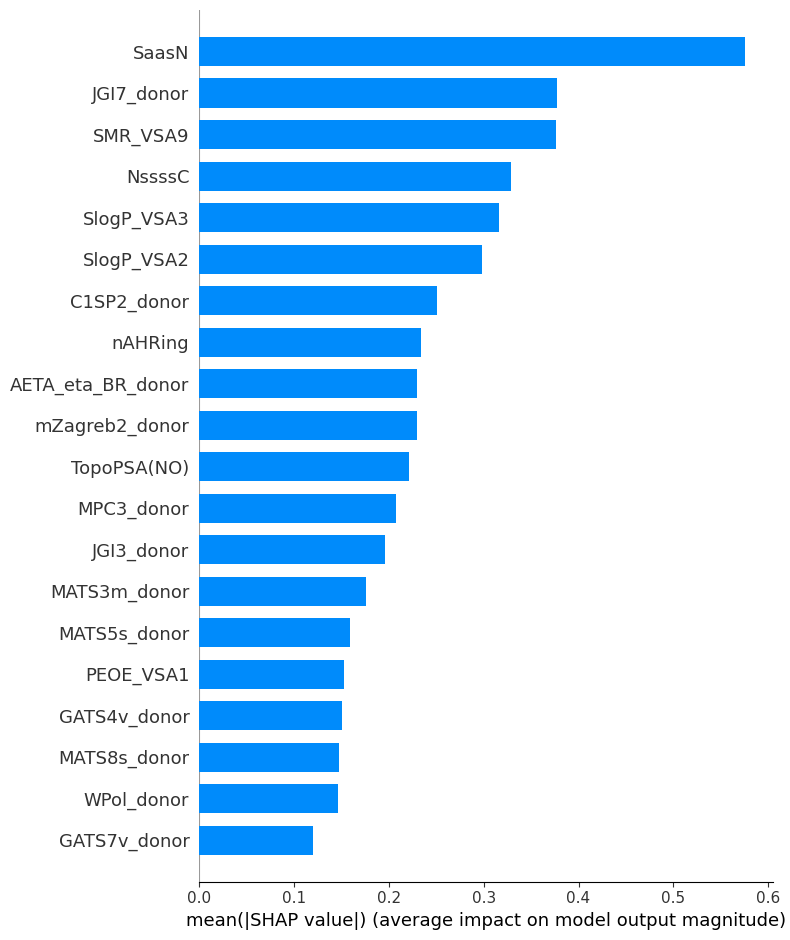

In [26]:
# With XGBOOST
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

# Compute mean SHAP values for each feature
feature_importance_values = shap_values.values
mean_shap_values = np.mean(np.abs(feature_importance_values), axis=0)

# Extract feature names from your dataset (assuming it's a pandas DataFrame)
feature_names = X.columns

# Create a dictionary to store feature names and their corresponding mean SHAP values
feature_importance_dict = dict(zip(feature_names, mean_shap_values))

# Sort the dictionary by mean SHAP values in descending order
xg_feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))



shap.summary_plot(shap_values, X, plot_type='bar', show=False)


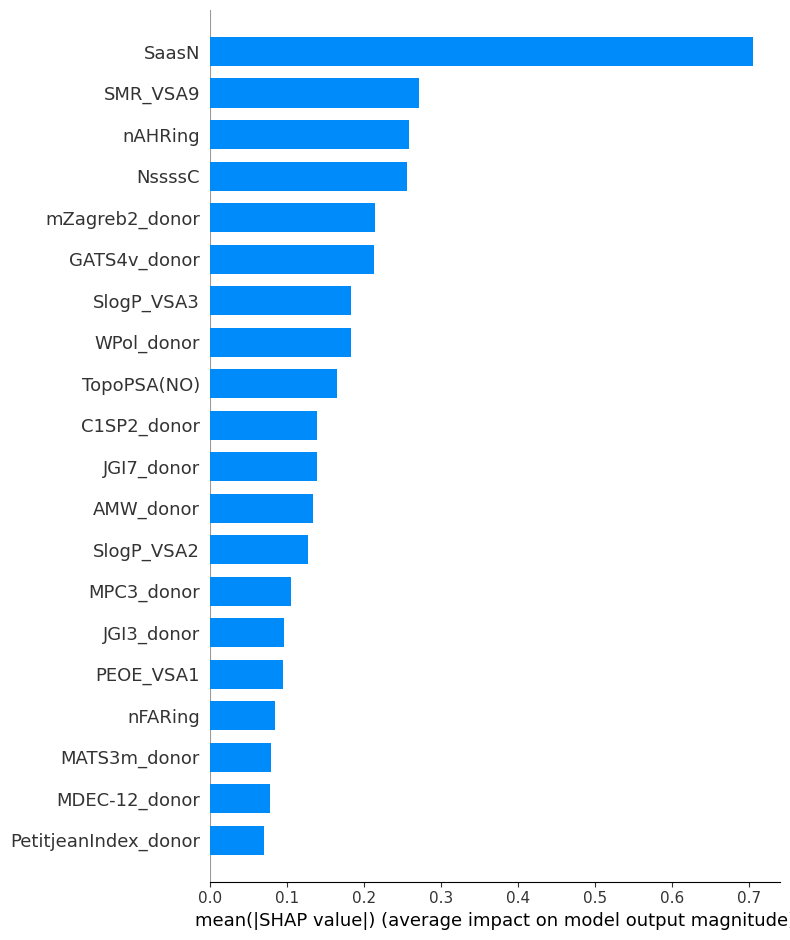

In [27]:
# # With Random Forest 
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

# Compute mean SHAP values for each feature
feature_importance_values = shap_values.values
mean_shap_values = np.mean(np.abs(feature_importance_values), axis=0)

# Extract feature names from your dataset (assuming it's a pandas DataFrame)
feature_names = X.columns

# Create a dictionary to store feature names and their corresponding mean SHAP values
feature_importance_dict = dict(zip(feature_names, mean_shap_values))

# Sort the dictionary by mean SHAP values in descending order
rf_feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))


shap.summary_plot(shap_values, X, plot_type='bar', show=False)



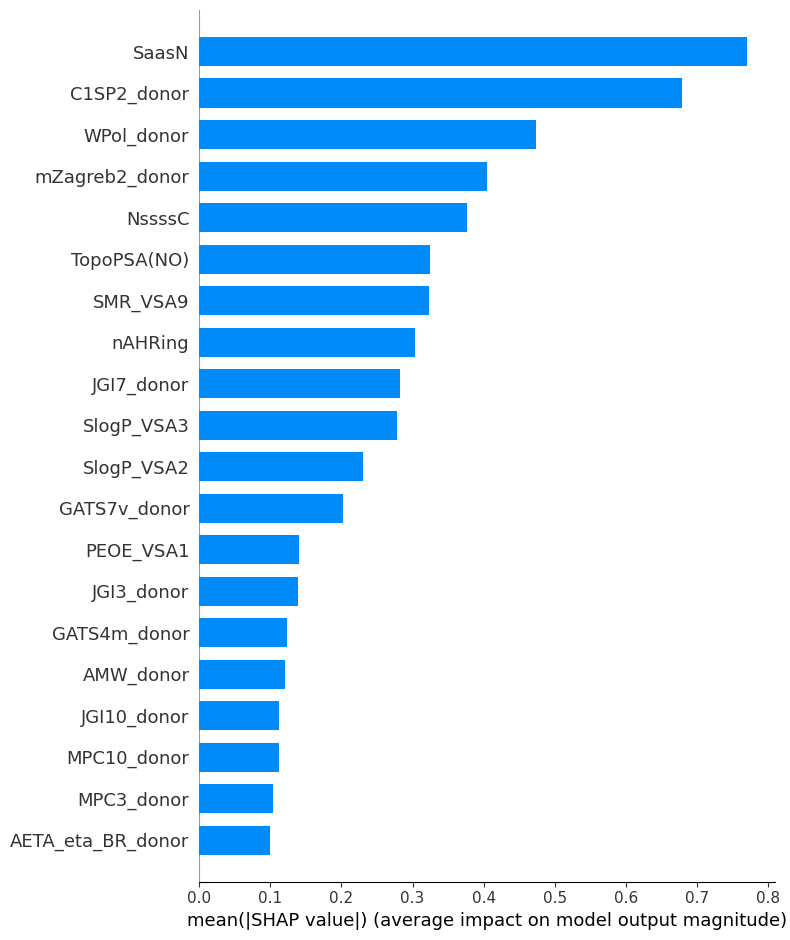

In [28]:
# With decesionTree
from sklearn.tree import DecisionTreeRegressor
# Entraînement du modèle
model = DecisionTreeRegressor(random_state=0)
model.fit(X, y)

# Calcul des valeurs d'importance avec SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Compute mean SHAP values for each feature
feature_importance_values = shap_values.values
mean_shap_values = np.mean(np.abs(feature_importance_values), axis=0)

# Extract feature names from your dataset (assuming it's a pandas DataFrame)
feature_names = X.columns

# Create a dictionary to store feature names and their corresponding mean SHAP values
feature_importance_dict = dict(zip(feature_names, mean_shap_values))

# Sort the dictionary by mean SHAP values in descending order
dt_feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))


# Display a barplot which show the importance of each features
shap.summary_plot(shap_values, X, plot_type='bar', show=False)

Permutation explainer: 1280it [18:48,  1.13it/s]


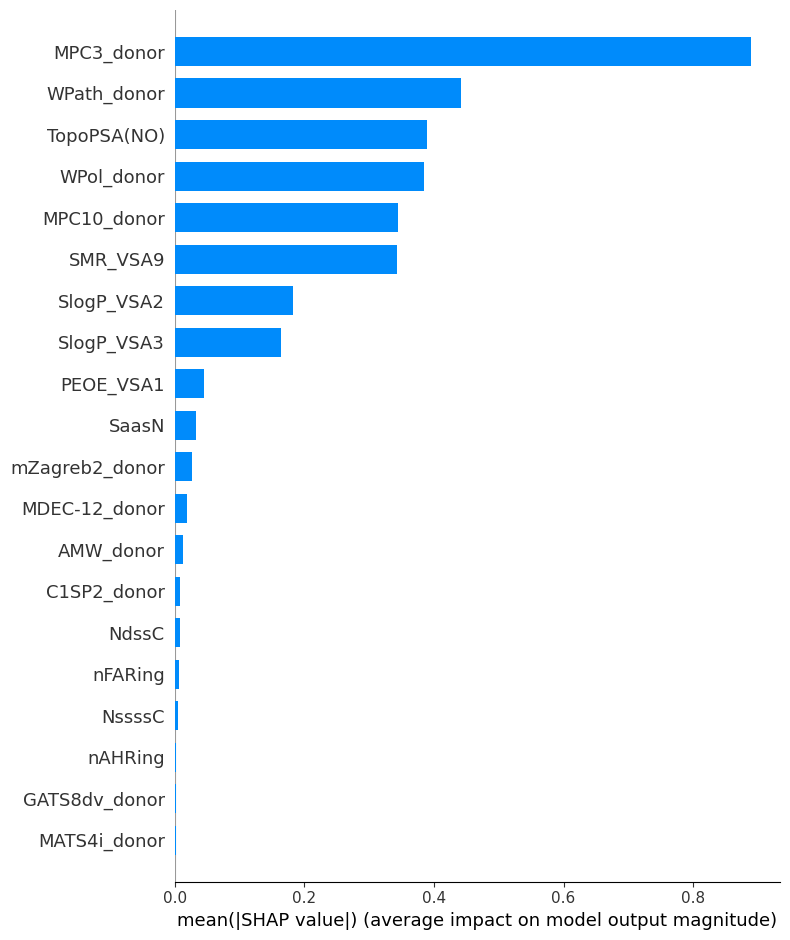

In [29]:
# With KNN
from sklearn.neighbors import KNeighborsRegressor


# Entraînement du modèle KNN
model = KNeighborsRegressor()
model.fit(X, y)

predict_function = lambda x: model.predict(x)

# Calcul des valeurs d'importance avec SHAP
explainer = shap.Explainer(predict_function, X)
shap_values = explainer(X)

# Compute mean SHAP values for each feature
feature_importance_values = shap_values.values
mean_shap_values = np.mean(np.abs(feature_importance_values), axis=0)

# Extract feature names from your dataset (assuming it's a pandas DataFrame)
feature_names = X.columns

# Create a dictionary to store feature names and their corresponding mean SHAP values
feature_importance_dict = dict(zip(feature_names, mean_shap_values))

# Sort the dictionary by mean SHAP values in descending order
knn_feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Display a barplot which show the importance of each features
shap.summary_plot(shap_values, X, plot_type='bar', show=False)

In [31]:

print(len(xg_feature_importance_dict))
print(list(xg_feature_importance_dict.keys())[:10])

F_xg=list(xg_feature_importance_dict.keys())[:10]
F_rf =list(rf_feature_importance_dict.keys())[:10]
F_dt =list(dt_feature_importance_dict.keys())[:10]
F_knn= list(knn_feature_importance_dict.keys())[:10]
F=[]

F=F_xg + F_dt + F_knn + F_rf

print(len(F))
F=set(F)
F=list(F)
print(len(F))

#F_after_removing_bad_feature = F_xg[-10:] and F_dt[-10:] and F_knn[-10:] and F_rf[-10:]
#F_after_removing_bad_feature = list(F - set(F_after_removing_bad_feature))
#print(len(F_after_removing_bad_feature))"""

38
['SaasN', 'JGI7_donor', 'SMR_VSA9', 'NssssC', 'SlogP_VSA3', 'SlogP_VSA2', 'C1SP2_donor', 'nAHRing', 'AETA_eta_BR_donor', 'mZagreb2_donor']
40
17


# Model Construction 

To select the appropriate regression model , we must train and validate differents models on our train/validation data and compare the metrics

* XGBoost
* Random Forest
* Desicion Trees
* K-nearest neighbors

In [72]:
# Input features selected according to the SHAP values.
X_without_shap_column = list(xg_feature_importance_dict.keys())
X = data[F]
y = data['PCE (%)']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)


In [73]:
X

WPath_donor  TopoPSA(NO)  SlogP_VSA2  WPol_donor  NssssC   SMR_VSA9  \
0              55   129.300003   11.566490          34     2.0  45.158081   
1              76   129.300003   11.566490        -109     2.0  45.158081   
2              58   164.940002   29.447769         -39     0.0  24.276886   
3            -127   129.300003   11.566490        -109     2.0  45.158081   
4            -127   129.300003   11.566490        -109     2.0  45.158081   
...           ...          ...         ...         ...     ...        ...   
1275          -76   129.300003   11.566490        -106     2.0  45.158081   
1276          -76   164.940002   29.447769        -106     0.0  24.276886   
1277          -76   129.300003   11.566490        -106     2.0  45.158081   
1278          -76   129.300003   11.566490        -106     2.0  45.158081   
1279          -76   129.300003   11.566490        -106     2.0  45.158081   

      MPC3_donor  C1SP2_donor  MPC10_donor  PEOE_VSA1  GATS4v_donor  nAHRing  \
0           -108            2          -46   0.000000      0.840846      0.0   
1            -40            5           43   0.000000      0.982564      0.0   
2             50            2          -86   9.134199      0.869058      0.0   
3            -56            2         -110   0.000000      0.940028      0.0   
4            -56            2         -110   0.000000      0.940028      0.0   
...          ...          ...          ...        ...           ...      ...   
1275         -46            8           36   0.000000      0.789861      0.0   
1276         -46            8           36   9.134199      0.789861      0.0   
1277         -46            8           36   0.000000      0.789861      0.0   
1278         -46            8           36   0.000000      0.789861      0.0   
1279         -46            8           36   0.000000      0.789861      0.0   

      mZagreb2_donor  AETA_eta_BR_donor  SlogP_VSA3     SaasN  JGI7_donor  
0          33.222221           0.028177   36.513268  0.000000    0.011634  
1          17.944445           0.023968   36.513268  0.000000    0.012157  
2          26.277779           0.024292   19.510334  4.560467    0.008202  
3          18.777779           0.025012   10.829981  0.000000    0.011975  
4          18.777779           0.025012   36.513268  0.000000    0.011975  
...              ...                ...         ...       ...         ...  
1275       18.944445           0.028105   10.829981  0.000000    0.016513  
1276       18.944445           0.028105   19.510334  4.560467    0.016513  
1277       18.944445           0.028105   36.513268  0.000000    0.016513  
1278       18.944445           0.028105   36.513268  0.000000    0.016513  
1279       18.944445           0.028105   36.513268  0.000000    0.016513  

[1279 rows x 17 columns]

In [74]:
def train_validate_models_results(X_train, y_train, X_validation, y_validation, models, metrics):
    results = []
    for name, model in models:
        model.fit(X_train, y_train)
        #print(name)
        y_pred = model.predict(X_validation)
        row = [name]
        for metric_name, metric_func in metrics.items():
            metric_value = metric_func(y_validation, y_pred)
            row.append(metric_value)
        results.append(row)
    df_results = pd.DataFrame(results, columns=['Model'] + list(metrics.keys()))
    return df_results



def plot_models_metrics(df, title):
    
    # Création d'un dataframe pour chaque metrics
    RMSE_df = df[['Model', 'RMSE']].copy()
    MAE_df = df[['Model', 'MAE']].copy()
    R2_df = df[['Model', 'R^2']].copy()
    
    
    # Melt the data frames
    RMSE_df = pd.melt(RMSE_df, id_vars=['Model'], var_name='metric', value_name='value')
    MAE_df = pd.melt(MAE_df, id_vars=['Model'], var_name='metric', value_name='value')
    R2_df = pd.melt(R2_df, id_vars=['Model'], var_name='metric', value_name='value')

    # Créer un bar chart pour chaque metrics
    plt.figure(figsize=(16, 6))
    plt.suptitle(title, fontsize=16)

    plt.subplot(1, 3, 1)
    sns.barplot(x="Model", y="value", data=RMSE_df)
    plt.title("RMSE")

    plt.subplot(1, 3, 2)
    sns.barplot(x="Model", y="value", data=MAE_df)
    plt.title("MAE")

    plt.subplot(1, 3, 3)
    sns.barplot(x="Model", y="value", data=R2_df)
    plt.title("R2")

    plt.tight_layout()
    plt.show()


models = [
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('XGBoost', xgb.XGBRegressor(random_state=42))
]


metrics = {
    'RMSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'R^2': r2_score
}


df=train_validate_models_results(X_train, y_train, X_validation, y_validation, models, metrics)
df

Model       RMSE       MAE       R^2
0  Decision Tree  12.784480  2.591242  0.100616
1  Random Forest   8.484623  2.283451  0.403109
2        XGBoost   9.798430  2.406437  0.310683

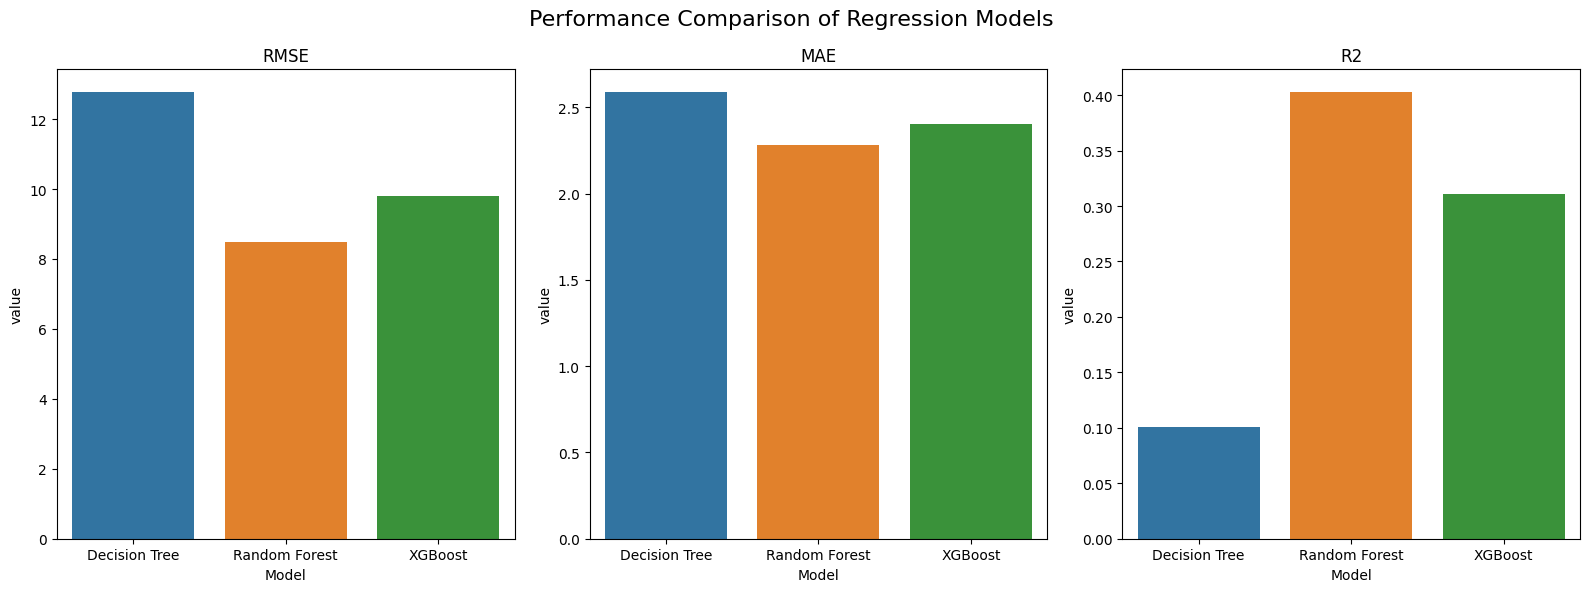

In [75]:
plot_models_metrics(df,title="Performance Comparison of Regression Models ")

In [76]:
def train_validate_models_results_cv(X, y, models, metrics, cv):
    results = []
    for model_name, model in models :
        row = [model_name]
        for metric_name, metric_func in metrics.items():
            scores = cross_val_score(model, X, y, cv=cv, scoring=metric_func)
            mean_score = np.mean(scores)
            row.append(mean_score)
        results.append(row)
    df_results = pd.DataFrame(results, columns=['Model'] + list(metrics.keys()))
    return df_results

import seaborn as sns

def plot_models_metrics_cv(df, title):
    
    # Création d'un dataframe pour chaque metrics
    RMSE_df = df[['Model', 'RMSE']].copy()
    MAE_df = df[['Model', 'MAE']].copy()
    R2_df = df[['Model', 'R^2']].copy()
    MAXE_df = df[['Model', 'Max Error']].copy()
    
    
    # Melt the data frames
    RMSE_df = pd.melt(RMSE_df, id_vars=['Model'], var_name='metric', value_name='value')
    MAE_df = pd.melt(MAE_df, id_vars=['Model'], var_name='metric', value_name='value')
    R2_df = pd.melt(R2_df, id_vars=['Model'], var_name='metric', value_name='value')
    MAXE_df = pd.melt(MAXE_df, id_vars=['Model'], var_name='metric', value_name='value')

    # Créer un bar chart pour chaque metrics
    plt.figure(figsize=(16, 8))
    plt.suptitle(title, fontsize=16)

    plt.subplot(2, 2, 1)
    sns.barplot(x="Model", y="value", data=RMSE_df)
    plt.title("RMSE")

    plt.subplot(2, 2, 2)
    sns.barplot(x="Model", y="value", data=MAE_df)
    plt.title("MAE")

    plt.subplot(2, 2, 3)
    sns.barplot(x="Model", y="value", data=R2_df)
    plt.title("R2")

    plt.subplot(2, 2, 4)
    sns.barplot(x="Model", y="value", data=MAXE_df)
    plt.title("Max Error")
    
    plt.tight_layout()
    plt.show()

models = [
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('XGBoost', xgb.XGBRegressor(random_state=42))
]


metrics = {
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'MAE': make_scorer(mean_absolute_error),
    'R^2': make_scorer(r2_score),
    'Max Error': make_scorer(max_error)
}


df_cv2=train_validate_models_results_cv(X, y, models, metrics,cv=2)
df_cv2

Model      RMSE       MAE       R^2  Max Error
0  Decision Tree  4.290094  3.227227 -0.423590  16.730000
1  Random Forest  3.256266  2.607759  0.179605  11.686158
2        XGBoost  3.735453  2.889385 -0.097846  14.796669

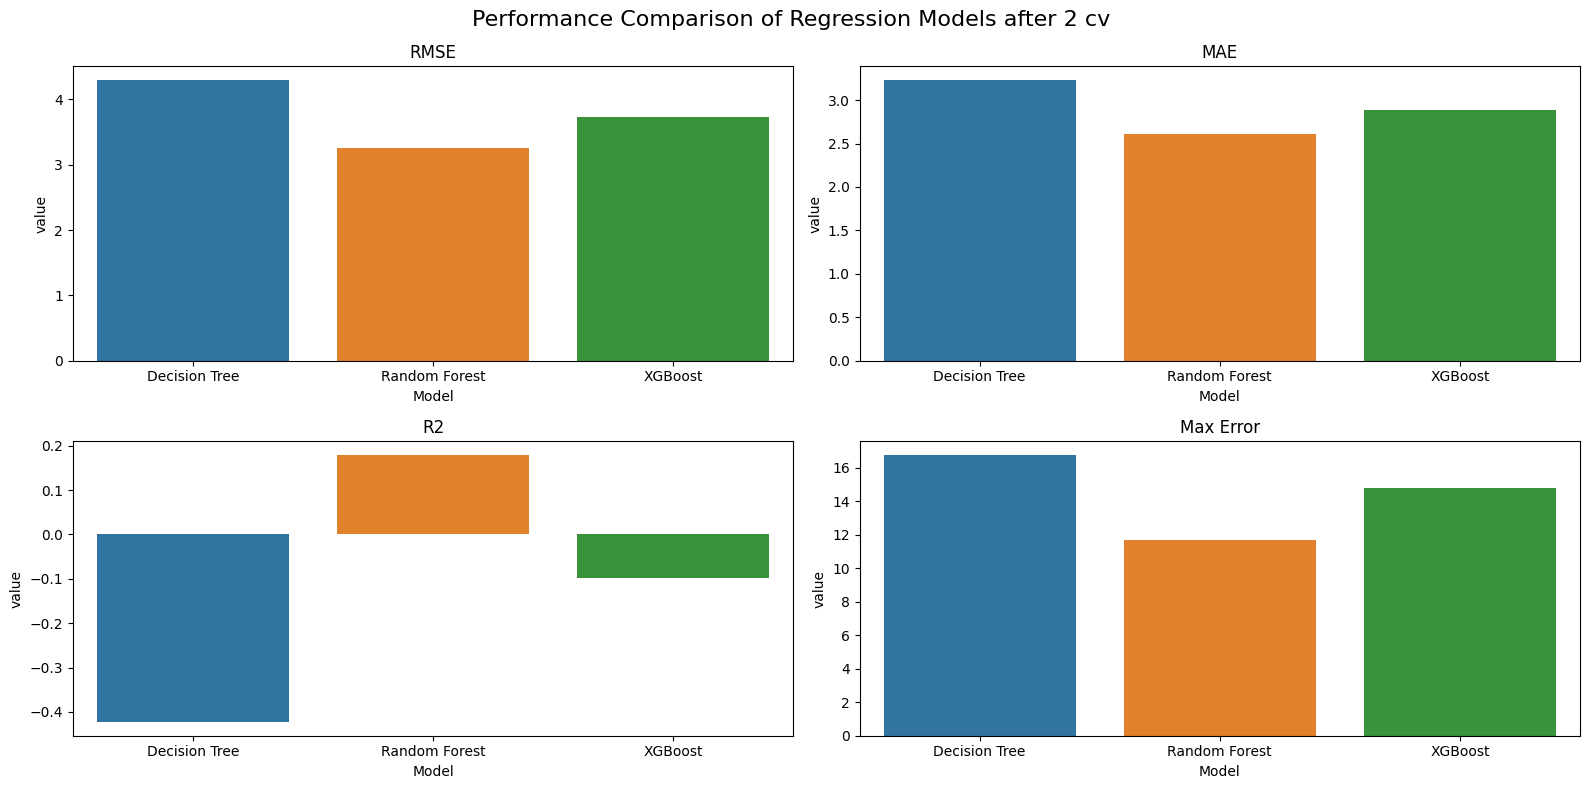

In [77]:
plot_models_metrics_cv(df_cv2,title="Performance Comparison of Regression Models after 2 cv ")

In [78]:
from sklearn.model_selection import GridSearchCV

def grid_search_models(models, params, X, y):
    results_df = pd.DataFrame(columns=['model', 'best_params', 'score'])

    for name, model in models.items():
        param_grid = params[name]
        grid = GridSearchCV(model, param_grid, cv=2,scoring='r2')
        grid.fit(X, y)
        
        best_params = grid.best_params_
        best_score = grid.best_score_  # convert back to positive MSE

        results_df = results_df.append({'model': name, 'best_params': best_params, 'score': best_score}, ignore_index=True)

    return results_df



models = {
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

params = {
    'Decision Tree Regressor': {'max_depth': [2, 4, 6,10]},
    'Random Forest Regressor': {'n_estimators': [50, 100,150,200 ]},
    'XGBoost':{'n_estimators': [30,50,100,500], 'max_depth': [None,2, 4, 6 ,10],'learning_rate': [0.01, 0.05, 0.1,0.2],'colsample_bytree': [0.3, 0.7]}
}         


df_cv2_gridsearch =grid_search_models(models, params, X, y)
df_cv2_gridsearch

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


model                                        best_params  \
0  Decision Tree Regressor                                   {'max_depth': 4}   
1  Random Forest Regressor                              {'n_estimators': 200}   
2                  XGBoost  {'colsample_bytree': 0.7, 'learning_rate': 0.1...   

      score  
0  0.042334  
1  0.180138  
2  0.188877

In [79]:
models = [
    ('Random Forest', RandomForestRegressor(n_estimators= 200,random_state=42)),
    ('XGBoost', xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.1, max_depth= 4, n_estimators= 100,random_state=42))
]


metrics = {
    'RMSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'R^2': r2_score
}


train_validate_models_results(X_train, y_train, X_validation, y_validation, models, metrics)


Model      RMSE       MAE       R^2
0  Random Forest  8.411428  2.267716  0.408259
1        XGBoost  7.927172  2.182835  0.442326

Optimization :

In [82]:
models = [
    ('svm',SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)),
    ('gbm', GradientBoostingRegressor( random_state=42)),
    ('XGBoost', xgb.XGBRegressor(random_state=42))
]
metrics = {
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'MAE': make_scorer(mean_absolute_error),
    'R^2': make_scorer(r2_score),
    'Max Error': make_scorer(max_error)
}
train_validate_models_results_cv(X, y, models, metrics,cv=2 )

Model      RMSE       MAE       R^2  Max Error
0      svm  4.469572  3.642805 -0.571595  10.706066
1      gbm  3.334626  2.609910  0.139057  12.969120
2  XGBoost  3.735453  2.889385 -0.097846  14.796669

In [83]:
models = {
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
}

params = {

  'Gradient Boosting Regressor': {'n_estimators': [50, 100, 200], 'max_depth': [2, 4, 6]}}


df_cv2_gridsearch =grid_search_models(models, params, X, y)
df_cv2_gridsearch

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


model                            best_params  \
0  Gradient Boosting Regressor  {'max_depth': 2, 'n_estimators': 100}   

      score  
0  0.177108

In [86]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# define the ANN model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(80, activation='relu'),
  tf.keras.layers.Dense(68, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1)
])

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.15)

# make predictions on the test set
y_pred_validation = model.predict(X_validation)

# evaluate the model performance
mse = mean_squared_error(y_validation, y_pred_validation)
rmse = np.sqrt(mse)
r2 = r2_score(y_validation, y_pred_validation)

print('ANN Regression Model Performance:')
print('MSE: ', mse)
print('RMSE: ', rmse)
print('R^2 Score: ', r2)

Epoch 1/100
28/28 [==============================] - 2s 11ms/step - loss: 16.3985 - mse: 16.3985 - val_loss: 11.6643 - val_mse: 11.6643
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 10.4507 - mse: 10.4507 - val_loss: 9.3082 - val_mse: 9.3082
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 9.1885 - mse: 9.1885 - val_loss: 8.7864 - val_mse: 8.7864
Epoch 4/100
28/28 [==============================] - 0s 6ms/step - loss: 9.0681 - mse: 9.0681 - val_loss: 11.2980 - val_mse: 11.2980
Epoch 5/100
28/28 [==============================] - 0s 6ms/step - loss: 9.3053 - mse: 9.3053 - val_loss: 11.2048 - val_mse: 11.2048
Epoch 6/100
28/28 [==============================] - 0s 6ms/step - loss: 11.1112 - mse: 11.1112 - val_loss: 11.6349 - val_mse: 11.6349
Epoch 7/100
28/28 [==============================] - 0s 6ms/step - loss: 9.2083 - mse: 9.2083 - val_loss: 9.4980 - val_mse: 9.4980
Epoch 8/100
28/28 [==============================] - 0s 6ms/step - l

In [257]:
# Create a StandardScalerobject , fit and transfrom data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


In [85]:
X.describe()

WPath_donor  TopoPSA(NO)   SlogP_VSA2   WPol_donor       NssssC  \
count  1279.000000  1279.000000  1279.000000  1279.000000  1279.000000   
mean     -5.110242   144.196808    25.885818    43.343237     1.612197   
std      76.038010    38.045109    20.811850    57.536328     1.007658   
min    -128.000000    37.380001     0.000000  -119.000000     0.000000   
25%     -76.000000   129.300003    11.566490    -6.000000     1.000000   
50%     -28.000000   129.300003    16.133589    66.000000     2.000000   
75%      83.000000   164.940002    31.467912    84.000000     2.000000   
max     127.000000   391.299988   148.647064   126.000000     6.000000   

          SMR_VSA9   MPC3_donor  C1SP2_donor  MPC10_donor    PEOE_VSA1  \
count  1279.000000  1279.000000  1279.000000  1279.000000  1279.000000   
mean     50.449898   -11.740422     3.240031   -11.393276     3.933452   
std      21.148384    64.556618     2.513393    54.412348     6.147455   
min       0.000000  -127.000000     0.000000  -127.000000     0.000000   
25%      43.785473   -52.000000     2.000000   -42.000000     0.000000   
50%      45.158081   -34.000000     2.000000   -23.000000     0.000000   
75%      64.666672    71.000000     5.000000    31.000000     9.134199   
max     163.400360   125.000000    20.000000   125.000000    39.199276   

       GATS4v_donor      nAHRing  mZagreb2_donor  AETA_eta_BR_donor  \
count   1279.000000  1279.000000     1279.000000        1279.000000   
mean       0.868682     0.352619       30.254957           0.027047   
std        0.066395     0.996853        8.503075           0.001444   
min        0.713872     0.000000        9.888889           0.019960   
25%        0.829159     0.000000       25.777779           0.026662   
50%        0.865050     0.000000       34.555557           0.026688   
75%        0.882764     0.000000       35.722221           0.028000   
max        1.059546     8.000000       54.055557           0.033745   

        SlogP_VSA3        SaasN   JGI7_donor  
count  1279.000000  1279.000000  1279.000000  
mean     30.649813     1.241679     0.011287  
std      15.100349     2.254770     0.001490  
min       0.000000     0.000000     0.006893  
25%      19.510334     0.000000     0.010665  
50%      36.513268     0.000000     0.010921  
75%      36.513268     2.425007     0.012034  
max     109.539803    13.244710     0.017656

# MODEL TEST (APPLICATION)


664 unique acceptors and 235 unique donors were identified. And so 664*235 combinations were generated, the corresponding smiles were identified and the descriptors were calculated to constitute our test dataset.

In [ ]:
"""['SaasN',
 'JGI7_donor',
 'SMR_VSA9',
 'NssssC',
 'SlogP_VSA3',
 'SlogP_VSA2',
 'C1SP2_donor',
 'nAHRing',
 'AETA_eta_BR_donor',
 'mZagreb2_donor',
 'TopoPSA(NO)',
 'MPC3_donor',
 'JGI3_donor',
 'MATS3m_donor',
 'MATS5s_donor',
 'PEOE_VSA1',
 'GATS4v_donor',
 'MATS8s_donor',
 'WPol_donor',
 'GATS7v_donor',
 'GATS8i_donor',
 'AMW_donor',
 'MATS4m_donor',
 'JGI10_donor',
 'nFARing',
 'NdssC',
 'n5AHRing',
 'MATS4s_donor',
 'GATS7i_donor',
 'MPC10_donor',
 'PetitjeanIndex_donor',
 'JGI8_donor',
 'WPath_donor',
 'GATS4m_donor',
 'JGI4_donor',
 'GATS8dv_donor',
 'MATS4i_donor',
 'MDEC-12_donor']"""